### En este código se ejecuan las ecuaciones diferenciales con el modelo completo, incluida la disipación.

In [2]:
# Librerias
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from qutip import *

Resolviendo sistema con kappa = 0.0000 a.u. ...
solve_ivp finalizado.
Resolviendo con QuTiP (incluyendo collapse operators)...


/home/luis/Documents/luis/Master/Thesis_Repository/Pulse-Optimization/.venv/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/home/luis/Documents/luis/Master/Thesis_Repository/Pulse-Optimization/.venv/lib/python3.12/site-packages/qutip/solver/solver_base.py:598: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


QuTiP finalizado.


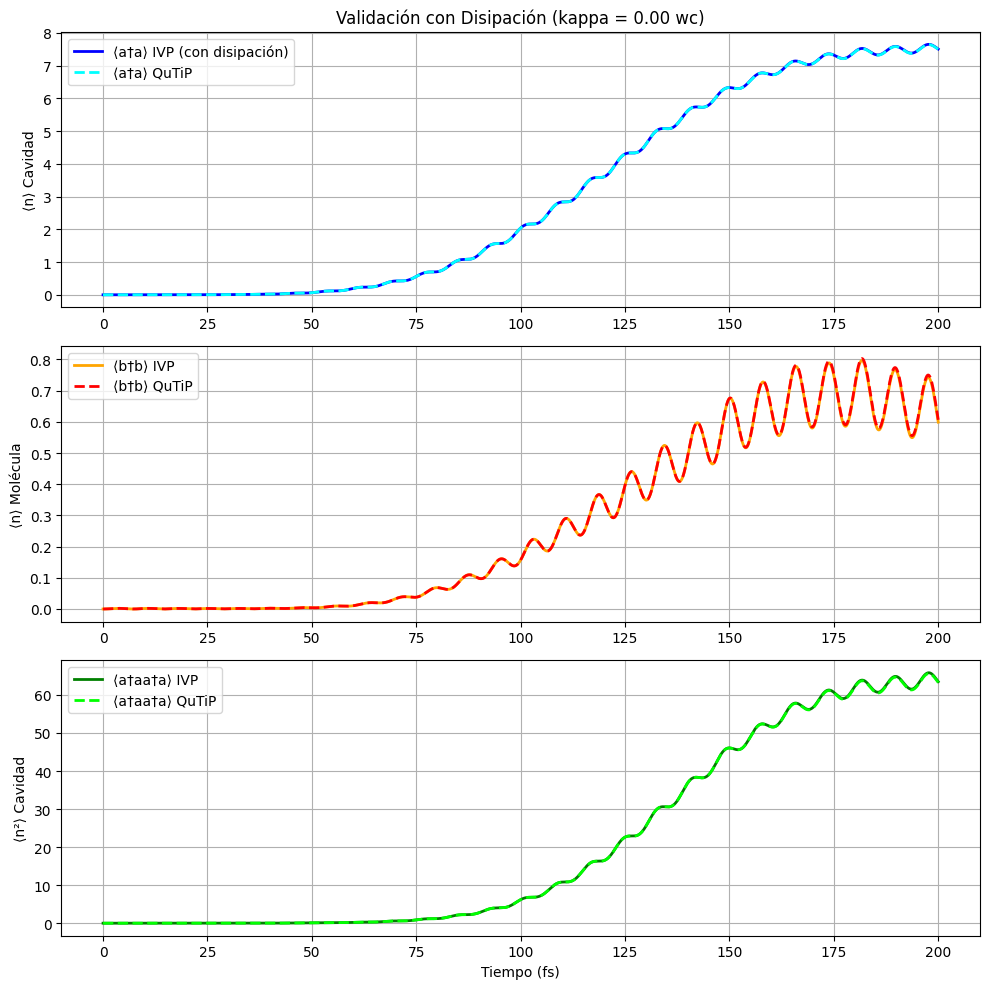

In [3]:
# ==============================================================================
# Parámetros y Constantes en Unidades Atómicas
# ==============================================================================
# Factores de conversión
au_cm1 = 2.1947463137e5
au_fs = 0.02418884326505

# Frecuencias de los modos (a.u.)
omega_0 = 2500 / au_cm1
omega_c = 0.85 * omega_0

# Parámetros del Hamiltoniano (a.u.) 
U_b = 0.01 * omega_0 

# === NUEVO: Parámetro de Disipación ===
kappa = 0.0 * omega_c 

# Parámetros del pulso láser (a.u.)
f0 = 0.15 * omega_c
pulse_duration_au = 200 / au_fs

# Parámetros de interacción dipolar extendida
E0 = 2.0 * omega_c  
d1 = 0.025             
d2 = 0.00026            

# ==============================================================================
# Función de pulso
# ==============================================================================
def f(t):
    val = f0 * np.sin(omega_c * t) * np.sin(np.pi * t / pulse_duration_au)**2
    # Forzar 0 fuera del rango (opcional pero recomendado para integración numérica estricta)
    return val if 0 <= t <= pulse_duration_au else 0.0

def f_t_qutip(t, args):
    return f(t)

# ==============================================================================
# Sistema de 15 Ecuaciones con Disipación de Cavidad
# ==============================================================================
def deriv_FME_final(t, y):
    A, B, C, D, E, F, G, H, I, J, K, L, M, N, O = y
    ft = f(t)
    x_a = D + C  # ⟨a†⟩ + ⟨a⟩

    # Aproximaciones de momentos de orden superior para 'b' (Cumulantes)
    approx_b_dag_b_sq = 2*B*E + F*M - 2*F*E**2
    approx_b_dag_sq_b = 2*B*F + N*E - 2*E*F**2
    approx_b_dag_b_cubed = -2*F*E**3 + 3*B*M
    approx_b_dag_cubed_b = np.conjugate(approx_b_dag_b_cubed)
    
    # Aproximaciones mixtas
    approx_a_dag_b_dag_sq_b = 2*H*B + I*N - 2*D*E*F**2 
    approx_a_dag_b_dag_b_sq = 2*I*B + H*M - 2*D*F*E**2
    
    # --- Cálculo de términos Hamiltonianos (Unitarios) ---
    
    # Auxiliares para Ecuaciones de Movimiento
    approx_a_dag_b_dag_sq = D*N + 2*F*H - 2*D*F**2
    approx_a_dag_b_dag_b = D*B + F*I + E*H - 2*D*F*E
    approx_a_dag_b_sq = D*M + 2*E*I - 2*D*E**2
    approx_a_b_dag_sq = C*N + 2*F*G - 2*C*F**2
    approx_a_b_dag_b = C*B + F*J + E*G - 2*C*F*E
    approx_a_b_sq = C*M + 2*E*J - 2*C*E**2
    
    term_d2_a_pop = E0*d2*(approx_a_dag_b_dag_sq + 2*approx_a_dag_b_dag_b + approx_a_dag_b_sq + D - (approx_a_b_dag_sq + 2*approx_a_b_dag_b + approx_a_b_sq + C))
    
    # 1. dA/dt (Número de fotones <a†a>)
    dA_dt = -1j * (E0*d1 * (H + I - G - J) + term_d2_a_pop + ft*(D - C))
    # ### DISIPACIÓN (-kappa * <a†a>) ###
    dA_dt += -kappa * A

    term_d2_b_pop = 2*E0*d2*(approx_a_dag_b_dag_sq - approx_a_dag_b_sq + approx_a_b_dag_sq - approx_a_b_sq)
    
    # 2. dB/dt (<b†b>) - Sin disipación directa
    dB_dt = -1j * (E0*d1 * (H - I + G - J) + term_d2_b_pop)

    # 3. dC/dt (<a>)
    dC_dt = -1j * (omega_c * C + E0*d1 * (F + E) + E0 * d2 * (N + 2*B + M + 1) + ft)
    # ### DISIPACIÓN (-kappa/2 * <a>) ###
    dC_dt += -(kappa/2) * C
    
    # 4. dD/dt (<a†>)
    dD_dt = np.conjugate(dC_dt)
    
    # 5. dE/dt (<b>) - Sin disipación directa
    dE_dt = -1j * (omega_0 * E - 2*U_b*approx_b_dag_b_sq + E0*d1*x_a + 2*E0*d2*(G + J + H + I))
    
    # 6. dF/dt (<b†>)
    dF_dt = np.conjugate(dE_dt)
    
    # 7. dK/dt (<a²>)
    dK_dt = -2j * (omega_c * K + E0*d1*(G + J) + E0*d2*(approx_a_b_dag_sq + 2*approx_a_b_dag_b + approx_a_b_sq + C) + ft*C)
    # ### DISIPACIÓN (-kappa * <a²>) ###
    dK_dt += -kappa * K
    
    # 8. dL/dt (<a†²>)
    dL_dt = np.conjugate(dK_dt)
    
    # 9. dM/dt (<b²>) - Sin disipación directa
    dM_dt = -2j * (omega_0*M - U_b*(2*approx_b_dag_b_cubed + M) + E0 * d1*(I + J) + E0*d2*(2*approx_a_dag_b_dag_b + D + 2*approx_a_dag_b_sq + 2*approx_a_b_dag_b + C + 2*approx_a_b_sq))
    
    # 10. dN/dt (<b†²>)
    dN_dt = np.conjugate(dM_dt)
    
    # Auxiliares para correlaciones cruzadas
    approx_a_dag_a_b = D*J + C*I + E*A - 2*D*C*E
    approx_a_dag_a_b_dag = D*G + C*H + F*A - 2*D*C*F
    approx_a_sq_b = 2*C*J + E*K - 2*C**2*E
    approx_a_sq_b_dag = 2*C*G + F*K - 2*C**2*F
    approx_b_cubed = 3*E*M - 2*E**3
    approx_b_b_dag_b = (2*E*B + F*M - 2*E**2*F) + E
    approx_b_b_dag_sq = (2*F*B + E*N - 2*F**2*E) + 2*F
    term_d2_ab = E0*d2*(2*(approx_a_dag_a_b + approx_a_dag_a_b_dag + approx_a_sq_b + approx_a_sq_b_dag) + approx_b_cubed + 2*approx_b_b_dag_b + approx_b_b_dag_sq + E)
    
    # 11. dJ/dt (<ab>)
    approx_a_dag_b_dag_sq_b = 2*H*B + I*N - 2*D*E*F**2 
    approx_a_b_dag_b_sq = np.conjugate(approx_a_dag_b_dag_sq_b)
    dJ_dt = -1j * ((omega_c+omega_0)*J - 2*U_b*approx_a_b_dag_b_sq + E0*d1*(A+K+B+M+1) + term_d2_ab + ft*E)
    # ### DISIPACIÓN (-kappa/2 * <ab>) ###
    dJ_dt += -(kappa/2) * J
    
    # 12. dH/dt (<a†b†>) -> Conjugado de J
    dH_dt = np.conjugate(dJ_dt)
    
    approx_b_dag_cubed = 3*F*N - 2*F**3
    approx_b_dag_b_b_dag = (2*F*B + E*N - 2*F**2*E) + F
    approx_b_sq_b_dag = 2*E*B + 2*E + F*M - 2*E**2*F
    approx_a_a_dag_b_dag = approx_a_dag_a_b_dag + F
    approx_a_a_dag_b = approx_a_dag_a_b + E
    term_d2_ab_dag = E0*d2*(approx_b_dag_cubed + 2*approx_b_dag_b_b_dag + approx_b_sq_b_dag + F - 2*(approx_a_sq_b_dag + approx_a_sq_b + approx_a_a_dag_b_dag + approx_a_a_dag_b))
    
    # 13. dG/dt (<ab†>)
    approx_a_dag_b_dag_b_sq = 2*I*B + H*M - 2*D*F*E**2
    approx_a_b_dag_sq_b = np.conjugate(approx_a_dag_b_dag_b_sq)
    dG_dt = -1j * ((omega_c-omega_0)*G + 2*U_b*approx_a_b_dag_sq_b - E0*d1*(A+K-B-N) + term_d2_ab_dag + ft*F)
    # ### DISIPACIÓN (-kappa/2 * <ab†>) ###
    dG_dt += -(kappa/2) * G
    
    # 14. dI/dt (<a†b>) -> Conjugado de G
    dI_dt = np.conjugate(dG_dt)

    # --- ECUACIÓN DE SEGUNDO ORDEN: dO/dt = d<a†aa†a>/dt ---
    term1_f = ft * ( (A + 1)*D + 3*D*A )
    term2_g = E0*d1 * ( 2*G*L + (A+1)*I + 3*A*I + (A+1)*H + 3*A*H - (A+1)*J - (A+1)*G - 3*J*A - 3*G*A + 2*J*L )
    term3 = -2*K * ( ft*D + E0*d1*(I + H) )
    term4 = 4*(C**2)*D * ( ft + E0*d1*(E+F) )
    term5 = -C * ( (A+1 + 3*A - 2*L)*ft + 4*(D**2)*(ft + (E+F)*E0*d1) )

    # Cumulantes para el término d2 (orden 5)
    approx_N_a_dag_b_dag_sq = approx_a_b_dag_sq * L + approx_a_dag_b_dag_sq * (2*A + 1) - 2 * C * N * D**2
    approx_N_a_dag_b_dag_b = approx_a_b_dag_b * L + approx_a_dag_b_dag_b * (2*A + 1) - 2 * C * B * D**2
    approx_N_a_dag_b_sq = approx_a_b_sq * L + approx_a_dag_b_sq * (2*A + 1) - 2 * C * M * D**2
    approx_a_dag_a_a_dag = (A + 1) * D - 2 * C * D**2 + D * A + C * L
    approx_N_a_b_sq = 2 * approx_a_b_sq * A + K * approx_a_dag_b_sq - 2 * C**2 * M * D
    approx_a_dag_N_b_dag_sq = np.conjugate(approx_N_a_b_sq) 
    approx_N_a_b_dag_b = 2 * approx_a_b_dag_b * A + K * approx_a_dag_b_dag_b - 2 * C**2 * B * D
    approx_a_dag_N_b_dag_b = np.conjugate(approx_N_a_b_dag_b)    
    approx_N_a_b_dag_sq = 2 * approx_a_b_dag_sq * A + K * approx_a_dag_b_dag_sq - 2 * C**2 * N * D
    approx_a_dag_N_b_sq  = np.conjugate(approx_N_a_b_dag_sq)    
    approx_a_dag_sq_a = -2 * C * D**2 + 2 * D * A + C * L

    d_N_sq_term_d2_pos = E0 * d2 * (
        approx_N_a_dag_b_dag_sq + 2 * approx_N_a_dag_b_dag_b + approx_N_a_dag_b_sq +
        approx_a_dag_a_a_dag + 
        approx_a_dag_N_b_dag_sq + 2 * approx_a_dag_N_b_dag_b + approx_a_dag_N_b_sq +
        approx_a_dag_sq_a      
    )
    
    approx_a_dag_a_a = -2 * C**2 * D + K * D + 2 * C * A
    approx_a_N_b_dag_sq = np.conjugate(approx_N_a_dag_b_sq) 
    approx_a_N_b_dag_b = np.conjugate(approx_N_a_dag_b_dag_b)
    approx_a_N_b_sq = np.conjugate(approx_N_a_dag_b_dag_sq) 
    approx_a_a_dag_a = C * (A + 1) - 2 * C**2 * D + K * D + C * A
    
    d_N_sq_term_d2_neg = E0 * d2 * (
        approx_N_a_b_dag_sq + 2 * approx_N_a_b_dag_b + approx_N_a_b_sq +
        approx_a_dag_a_a +      
        approx_a_N_b_dag_sq + 2 * approx_a_N_b_dag_b + approx_a_N_b_sq +
        approx_a_a_dag_a        
    )

    d_N_sq_term_d2 = d_N_sq_term_d2_pos - d_N_sq_term_d2_neg

    dO_dt = -1j * (term1_f + term2_g + term3 + term4 + term5 + d_N_sq_term_d2)
    # ### DISIPACIÓN (-2*kappa * <n^2> + kappa * <n>) ###
    # O = <n^2>, A = <n>
    dO_dt += -2 * kappa * O + kappa * A

    return np.array([dA_dt, dB_dt, dC_dt, dD_dt, dE_dt, dF_dt, dG_dt, dH_dt,
                     dI_dt, dJ_dt, dK_dt, dL_dt, dM_dt, dN_dt, dO_dt], dtype=complex)

# ==============================================================================
# Solución Numérica con solve_ivp
# ==============================================================================
y0 = np.zeros(15, dtype=complex)
t_span = (0, pulse_duration_au)
t_eval = np.linspace(*t_span, 7000)

print(f"Resolviendo sistema con kappa = {kappa:.4f} a.u. ...")
sol_ivp = solve_ivp(deriv_FME_final, t_span, y0, t_eval=t_eval, method='DOP853', rtol=1e-7, atol=1e-9)
print("solve_ivp finalizado.")

# ==============================================================================
# Método 2: QuTiP (Benchmark con Lindblad)
# ==============================================================================
print("Resolviendo con QuTiP (incluyendo collapse operators)...")
N1, N2 = 30, 15 # Reduje un poco la dimensión por velocidad, auméntalo si es necesario
a, b = tensor(destroy(N1), qeye(N2)), tensor(qeye(N1), destroy(N2))
x_a, x_b = a.dag() + a, b.dag() + b

H_sys = omega_c*a.dag()*a + omega_0*b.dag()*b
H_anharmonic = -U_b * b.dag()*b.dag()*b*b
H_int = E0 * d1 * x_a * x_b + E0 * d2 * x_a * x_b * x_b
H0 = H_sys + H_anharmonic + H_int
H = [H0, [x_a, f_t_qutip]]

# === AGREGAR LISTA DE OPERADORES DE COLAPSO ===
c_ops = []

psi0 = tensor(basis(N1, 0), basis(N2, 0))
e_ops = [
    a.dag()*a, b.dag()*b, 
    a.dag()*a*a.dag()*a # <n^2> para verificar O
]

# Usamos mesolve en lugar de sesolve para Ecuación Maestra
result_qutip = mesolve(H, psi0, t_eval, c_ops, e_ops, options=Options(atol=1e-9))
print("QuTiP finalizado.")

# ==============================================================================
# Visualización Comparativa
# ==============================================================================

plt.figure(figsize=(10, 10))

# 1. Número de fotones (Cavidad y Molécula)
plt.subplot(3, 1, 1)
plt.plot(sol_ivp.t * au_fs, sol_ivp.y[0].real, label='⟨a†a⟩ IVP (con disipación)', color='blue', linewidth=2)
plt.plot(t_eval * au_fs, result_qutip.expect[0], label='⟨a†a⟩ QuTiP', color='cyan', linestyle='--', linewidth=2)
plt.ylabel('⟨n⟩ Cavidad')
plt.title(f'Validación con Disipación (kappa = {kappa/omega_c:.2f} wc)')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(sol_ivp.t * au_fs, sol_ivp.y[1].real, label='⟨b†b⟩ IVP', color='orange', linewidth=2)
plt.plot(t_eval * au_fs, result_qutip.expect[1], label='⟨b†b⟩ QuTiP', color='red', linestyle='--', linewidth=2)
plt.ylabel('⟨n⟩ Molécula')
plt.legend()
plt.grid(True)

# 2. Número cuadrado de fotones (para Mandel Q)
plt.subplot(3, 1, 3)
plt.plot(sol_ivp.t * au_fs, sol_ivp.y[14].real, label='⟨a†aa†a⟩ IVP', color='green', linewidth=2)
plt.plot(t_eval * au_fs, result_qutip.expect[2], label='⟨a†aa†a⟩ QuTiP', color='lime', linestyle='--', linewidth=2)
plt.xlabel('Tiempo (fs)')
plt.ylabel('⟨n²⟩ Cavidad')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Si se requieren comprobaciones rapidas aquí se deja el código sin colapsos en QuTiP para que no tarde tanto.

Resolviendo con solve_ivp (sistema de 14 ecuaciones)...
solve_ivp finalizado.
Resolviendo con QuTiP (usando el Hamiltoniano)...
QuTiP finalizado.


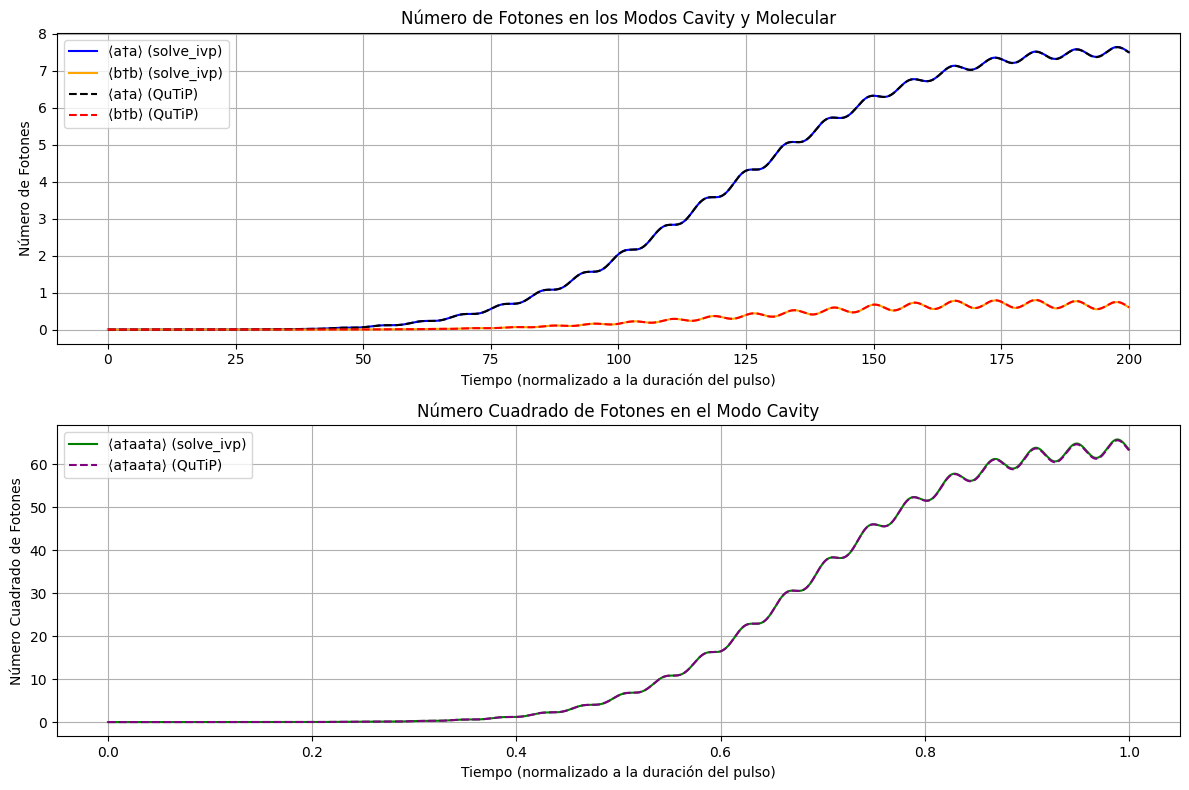

In [ ]:
# ==============================================================================
# Parámetros y Constantes en Unidades Atómicas
# ==============================================================================
# Factores de conversión
au_cm1 = 2.1947463137e5
au_fs = 0.02418884326505

# Frecuencias de los modos (a.u.)
omega_0 = 2500 / au_cm1
omega_c = 0.85*omega_0

# Parámetros del Hamiltoniano (a.u.)
g = 0.05 * omega_c   # Acoplamiento
U_b = 0.01 * omega_0 # Anarmonicidad

# Parámetros del pulso láser (a.u.)
f0 = 0.15* omega_c
pulse_duration_au = 200 / au_fs


# Nuevos parámetros de acoplamiento (valores de ejemplo, ajústalos según sea necesario)
E0 = 2.0 * omega_c  # Amplitud del campo eléctrico
d1 = 0.025             # Coeficiente dipolar de primer orden
d2 = 0.00026            # Coeficiente dipolar de segundo orden


# ==============================================================================
# Función de pulso
# ==============================================================================
# ==============================================================================
def f(t):
    return f0 * np.sin(omega_c * t) * np.sin(np.pi * t / pulse_duration_au)**2

def f_t_qutip(t, args):
    """
    Define un pulso láser externo f(t) para QuTiP.
    """
    return f(t)



# ==============================================================================
# Sistema de 15 Ecuaciones con Expansión Cumulante Completa
# ==============================================================================
# Orden del vector de estado y:
# 00: A:⟨a†a⟩,   01: B:⟨b†b⟩,   02: C:⟨a⟩,    03: D:⟨a†⟩,      04: E:⟨b⟩, 
# 05: F:⟨b†⟩,    06: G:⟨ab†⟩,   07: H:⟨a†b†⟩,  08: I:⟨a†b⟩,     09: J:⟨ab⟩, 
# 10: K:⟨a²⟩,    11: L:⟨a†²⟩,   12: M:⟨b²⟩,    13: N:⟨b†²⟩,     14: O:⟨a†aa†a⟩

def deriv_FME_final(t, y):
    A, B, C, D, E, F, G, H, I, J, K, L, M, N, O = y
    ft = f(t)
    x_a = D + C  # ⟨a†⟩ + ⟨a⟩

    # Aproximaciones de momentos de orden superior para 'b'
    approx_b_dag_b_sq = 2*B*E + F*M - 2*F*E**2
    approx_b_dag_sq_b = 2*B*F + N*E - 2*E*F**2
    approx_b_dag_b_cubed = -2*F*E**3 + 3*B*M
    approx_b_dag_cubed_b = np.conjugate(approx_b_dag_b_cubed)
    approx_a_dag_b_dag_sq_b = 2*H*B + I*N - 2*D*E*F**2 
    approx_a_b_dag_b_sq = np.conjugate(approx_a_dag_b_dag_sq_b)
    approx_a_dag_b_dag_b_sq = 2*I*B + H*M - 2*D*F*E**2
    approx_a_b_dag_sq_b = np.conjugate(approx_a_dag_b_dag_b_sq)
    
    # --- Ecuaciones diferenciales ---
    approx_a_dag_b_dag_sq = D*N + 2*F*H - 2*D*F**2
    approx_a_dag_b_dag_b = D*B + F*I + E*H - 2*D*F*E
    approx_a_dag_b_sq = D*M + 2*E*I - 2*D*E**2
    approx_a_b_dag_sq = C*N + 2*F*G - 2*C*F**2
    approx_a_b_dag_b = C*B + F*J + E*G - 2*C*F*E
    approx_a_b_sq = C*M + 2*E*J - 2*C*E**2
    term_d2_a_pop = E0*d2*(approx_a_dag_b_dag_sq + 2*approx_a_dag_b_dag_b + approx_a_dag_b_sq + D - (approx_a_b_dag_sq + 2*approx_a_b_dag_b + approx_a_b_sq + C))
    dA_dt = -1j * (E0*d1 * (H + I - G - J) + term_d2_a_pop +ft*(D - C))

    term_d2_b_pop = 2*E0*d2*(approx_a_dag_b_dag_sq - approx_a_dag_b_sq + approx_a_b_dag_sq - approx_a_b_sq)
    dB_dt = -1j * (E0*d1 * (H - I + G - J) + term_d2_b_pop)

    
    dC_dt = -1j * (omega_c * C + E0*d1 * (F + E) + E0 * d2 * (N + 2*B + M + 1) +ft)
    dD_dt = np.conjugate(dC_dt)
    
    dE_dt = -1j * (omega_0 * E - 2*U_b*approx_b_dag_b_sq + E0*d1*x_a + 2*E0*d2*(G + J + H + I))
    dF_dt = np.conjugate(dE_dt)
    
    dK_dt = -2j * (omega_c * K + E0*d1*(G + J) + E0*d2*(approx_a_b_dag_sq + 2*approx_a_b_dag_b + approx_a_b_sq + C)  +ft*C)
    dL_dt = np.conjugate(dK_dt)
    
    dM_dt = -2j * (omega_0*M - U_b*(2*approx_b_dag_b_cubed + M) + E0 * d1*(I + J) + E0*d2*(2*approx_a_dag_b_dag_b + D + 2*approx_a_dag_b_sq + 2*approx_a_b_dag_b + C + 2*approx_a_b_sq))
    dN_dt = np.conjugate(dM_dt)
    

    approx_a_dag_a_b = D*J + C*I + E*A - 2*D*C*E
    approx_a_dag_a_b_dag = D*G + C*H + F*A - 2*D*C*F
    approx_a_sq_b = 2*C*J + E*K - 2*C**2*E
    approx_a_sq_b_dag = 2*C*G + F*K - 2*C**2*F
    approx_b_cubed = 3*E*M - 2*E**3
    approx_b_b_dag_b = (2*E*B + F*M - 2*E**2*F) + E
    approx_b_b_dag_sq = (2*F*B + E*N - 2*F**2*E) + 2*F
    term_d2_ab = E0*d2*(2*(approx_a_dag_a_b + approx_a_dag_a_b_dag + approx_a_sq_b + approx_a_sq_b_dag) + approx_b_cubed + 2*approx_b_b_dag_b + approx_b_b_dag_sq + E)
    dJ_dt = -1j * ((omega_c+omega_0)*J - 2*U_b*approx_a_b_dag_b_sq + E0*d1*(A+K+B+M+1) + term_d2_ab +ft*E)
    dH_dt = np.conjugate(dJ_dt)
    
    approx_b_dag_cubed = 3*F*N - 2*F**3
    approx_b_dag_b_b_dag = (2*F*B + E*N - 2*F**2*E) + F
    approx_b_sq_b_dag = 2*E*B + 2*E + F*M - 2*E**2*F
    approx_a_a_dag_b_dag = approx_a_dag_a_b_dag + F
    approx_a_a_dag_b = approx_a_dag_a_b + E
    term_d2_ab_dag = E0*d2*(approx_b_dag_cubed + 2*approx_b_dag_b_b_dag + approx_b_sq_b_dag + F - 2*(approx_a_sq_b_dag + approx_a_sq_b + approx_a_a_dag_b_dag + approx_a_a_dag_b))
    dG_dt = -1j * ((omega_c-omega_0)*G + 2*U_b*approx_a_b_dag_sq_b - E0*d1*(A+K-B-N) + term_d2_ab_dag +ft*F)
    dI_dt = np.conjugate(dG_dt)

    # --- NUEVA ECUACIÓN: dO/dt = d<a†aa†a>/dt ---
    term1_f = ft * ( (A + 1)*D + 3*D*A )
    
    term2_g = E0*d1 * ( 2*G*L + (A+1)*I + 3*A*I + \
                    (A+1)*H + 3*A*H - (A+1)*J - (A+1)*G - 3*J*A - 3*G*A + \
                    2*J*L )
                    
    term3 = -2*K * ( ft*D + E0*d1*(I + H) )

    term4 = 4*(C**2)*D * ( ft + E0*d1*(E+F) )
    
    term5 = -C * ( (A+1 + 3*A - 2*L)*ft + 4*(D**2)*(ft + (E+F)*E0*d1) )

    approx_N_a_dag_b_dag_sq = approx_a_b_dag_sq * L + approx_a_dag_b_dag_sq * (2*A + 1) - 2 * C * N * D**2
    approx_N_a_dag_b_dag_b = approx_a_b_dag_b * L + approx_a_dag_b_dag_b * (2*A + 1) - 2 * C * B * D**2
    approx_N_a_dag_b_sq = approx_a_b_sq * L + approx_a_dag_b_sq * (2*A + 1) - 2 * C * M * D**2
    approx_a_dag_a_a_dag = (A + 1) * D - 2 * C * D**2 + D * A + C * L
    approx_N_a_b_sq = 2 * approx_a_b_sq * A + K * approx_a_dag_b_sq - 2 * C**2 * M * D
    approx_a_dag_N_b_dag_sq = np.conjugate(approx_N_a_b_sq) # <a† a†a b†b†>
    approx_N_a_b_dag_b = 2 * approx_a_b_dag_b * A + K * approx_a_dag_b_dag_b - 2 * C**2 * B * D
    approx_a_dag_N_b_dag_b = np.conjugate(approx_N_a_b_dag_b)     # <a† a†a b†b>
    approx_N_a_b_dag_sq = 2 * approx_a_b_dag_sq * A + K * approx_a_dag_b_dag_sq - 2 * C**2 * N * D
    approx_a_dag_N_b_sq  = np.conjugate(approx_N_a_b_dag_sq)    # <a† a†a b b>
    approx_a_dag_sq_a = -2 * C * D**2 + 2 * D * A + C * L
    d_N_sq_term_d2_pos = E0 * d2 * (
        approx_N_a_dag_b_dag_sq + 2 * approx_N_a_dag_b_dag_b + approx_N_a_dag_b_sq +
        approx_a_dag_a_a_dag +  # Este es <N a†>
        approx_a_dag_N_b_dag_sq + 2 * approx_a_dag_N_b_dag_b + approx_a_dag_N_b_sq +
        approx_a_dag_sq_a      # Este es <a† N>
    )
    
    # Parte "negativa" (con a)
    # <N a b†²> + 2<N a b†b> + <N a b²> + <N a> +
    # <a N b†²> + 2<a N b†b> + <a N b²> + <a N>
    approx_a_dag_a_a = -2 * C**2 * D + K * D + 2 * C * A
    approx_a_N_b_dag_sq = np.conjugate(approx_N_a_dag_b_sq) 
    approx_a_N_b_dag_b = np.conjugate(approx_N_a_dag_b_dag_b)
    approx_a_N_b_sq = np.conjugate(approx_N_a_dag_b_dag_sq) 
    approx_a_a_dag_a = C * (A + 1) - 2 * C**2 * D + K * D + C * A
    d_N_sq_term_d2_neg = E0 * d2 * (
        approx_N_a_b_dag_sq + 2 * approx_N_a_b_dag_b + approx_N_a_b_sq +
        approx_a_dag_a_a +      # Este es <N a>
        approx_a_N_b_dag_sq + 2 * approx_a_N_b_dag_b + approx_a_N_b_sq +
        approx_a_a_dag_a        # Este es <a N>
    )

    d_N_sq_term_d2 = d_N_sq_term_d2_pos - d_N_sq_term_d2_neg


    dO_dt = -1j * (term1_f + term2_g + term3 + term4 + term5 + d_N_sq_term_d2)

    return np.array([dA_dt, dB_dt, dC_dt, dD_dt, dE_dt, dF_dt, dG_dt, dH_dt,
                     dI_dt, dJ_dt, dK_dt, dL_dt, dM_dt, dN_dt, dO_dt], dtype=complex)

# ==============================================================================
# Solución Numérica
# ==============================================================================
y0 = np.zeros(15, dtype=complex)
t_span = (0, pulse_duration_au)
t_eval = np.linspace(*t_span, 7000)

print("Resolviendo con solve_ivp (sistema de 14 ecuaciones)...")
sol_ivp = solve_ivp(deriv_FME_final, t_span, y0, t_eval=t_eval, method='DOP853', rtol=1e-7, atol=1e-9)
print("solve_ivp finalizado.")

# --- Método 2: QuTiP ---
print("Resolviendo con QuTiP (usando el Hamiltoniano)...")
N1, N2 = 51, 51
a, b = tensor(destroy(N1), qeye(N2)), tensor(qeye(N1), destroy(N2))
x_a, x_b = a.dag() + a, b.dag() + b

H_sys = omega_c*a.dag()*a + omega_0*b.dag()*b
H_anharmonic = -U_b * b.dag()*b.dag()*b*b
H_int = E0 * d1 * x_a * x_b + E0 * d2 * x_a * x_b * x_b
H0 = H_sys + H_anharmonic + H_int
H = [H0, [x_a, f_t_qutip]]

psi0 = tensor(basis(N1, 0), basis(N2, 0))
e_ops = [
    a.dag()*a, b.dag()*b, a, a.dag(), b, b.dag(), a*b.dag(), a.dag()*b.dag(),
    a.dag()*b, a*b, a**2, a.dag()**2, b**2, b.dag()**2, a.dag()*a*a.dag()*a
]

result_qutip = mesolve(H, psi0, t_eval, [], e_ops, options=Options(atol=1e-9))
print("QuTiP finalizado.")

# ==============================================================================
# Visualización de Resultados número y número cuadrado de fotones
# ==============================================================================

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(sol_ivp.t  * au_fs, sol_ivp.y[0].real, label='⟨a†a⟩ (solve_ivp)', color='blue')
plt.plot(sol_ivp.t  * au_fs, sol_ivp.y[1].real, label='⟨b†b⟩ (solve_ivp)', color='orange')
plt.plot(t_eval * au_fs, result_qutip.expect[0], label='⟨a†a⟩ (QuTiP)', color='black', linestyle='--')
plt.plot(t_eval * au_fs, result_qutip.expect[1], label='⟨b†b⟩ (QuTiP)', color='red', linestyle='--')
plt.title('Número de Fotones en los Modos Cavity y Molecular')
plt.xlabel('Tiempo (normalizado a la duración del pulso)')
plt.ylabel('Número de Fotones')
plt.legend()
plt.grid()
plt.subplot(2, 1, 2)
#plt.ylim(0, 0.005)
#plt.xlim(0, 0.2)
plt.plot(sol_ivp.t / pulse_duration_au, sol_ivp.y[14].real, label='⟨a†aa†a⟩ (solve_ivp)', color='green')
plt.plot(t_eval / pulse_duration_au, result_qutip.expect[14], label='⟨a†aa†a⟩ (QuTiP)', color='purple', linestyle='--')
plt.title('Número Cuadrado de Fotones en el Modo Cavity')
plt.xlabel('Tiempo (normalizado a la duración del pulso)')
plt.ylabel('Número Cuadrado de Fotones')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()  